- Phương pháp 1: Mô hình VGG16:

In [ ]:
# Import các thư viện cần thiết:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

# 1. Chuẩn bị dữ liệu:

In [ ]:
# Mount tới drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


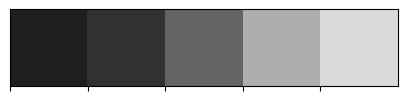

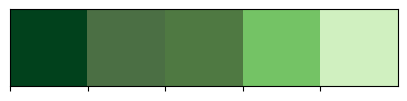

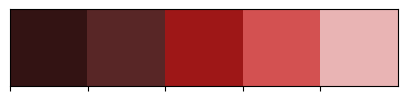

In [ ]:
# Colors sẽ sử dụng:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
# Tập nhãn:
labels = ['glioma','meningioma','notumor', 'pituitary']

## 1.1. Load dữ liệu train:

In [ ]:
import zipfile
import os

# Tải lên dataset và giải nén:
zip_path = "/content/drive/MyDrive/Image_Processing_Application/Đồ Án/Epic and CSCR hospital Dataset.zip"
extract_path = "/content/brain_tumor"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extracted!")

Extracted!


In [ ]:
train_dir = "/content/brain_tumor/Epic and CSCR hospital Dataset/Train"
test_dir  = "/content/brain_tumor/Epic and CSCR hospital Dataset/Test"

In [ ]:
# Đọc dữ liệu:
X_train_data = []
y_train_data = []
X_test_data = []
y_test_data = []
image_size = 224

# Load training data
for i in labels:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading training {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train_data.append(img)
        y_train_data.append(i)

# Load testing data
for i in labels:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading testing {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test_data.append(img)
        y_test_data.append(i)

X_train_data = np.array(X_train_data)
y_train_data = np.array(y_train_data)
X_test_data = np.array(X_test_data)
y_test_data = np.array(y_test_data)

print(f"Original training data shape: {X_train_data.shape}")
print(f"Original testing data shape: {X_test_data.shape}")

Loading testing pituitary: 100%|██████████| 626/626 [00:01<00:00, 480.55it/s]


Original training data shape: (9650, 224, 224, 3)
Original testing data shape: (2414, 224, 224, 3)


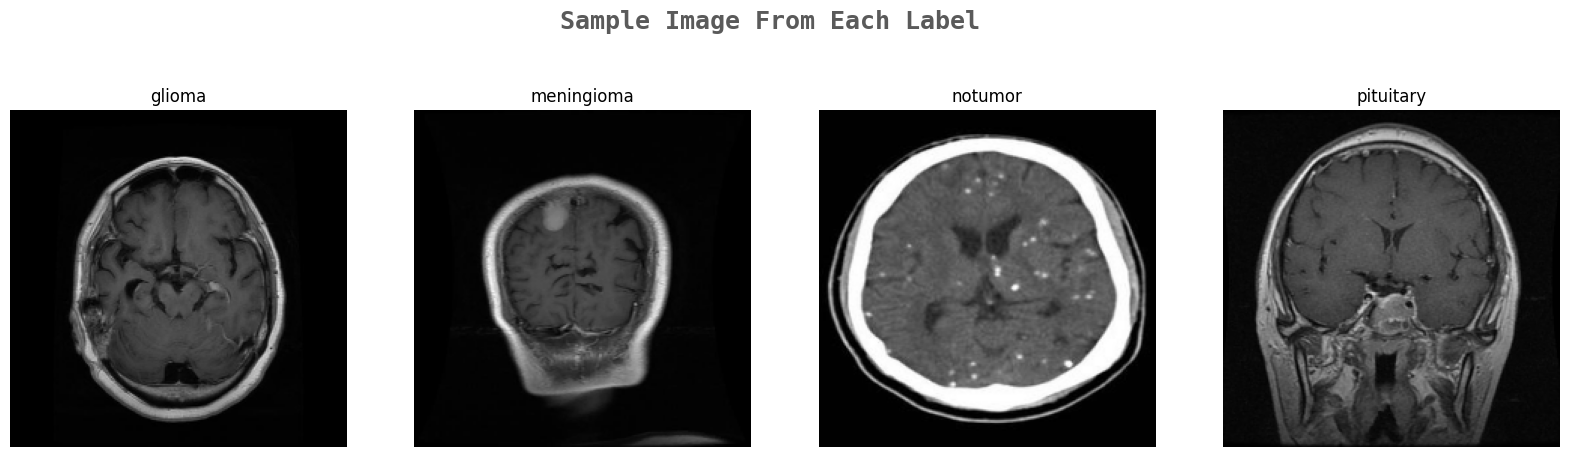

In [ ]:
# In ra một vài mẫu dữ liệu:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train_data[j]==i:
            ax[k].imshow(X_train_data[j])
            ax[k].set_title(y_train_data[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
# Gộp train và test thành tập train hoàn chỉnh:
X_train_data = np.concatenate((X_train_data, X_test_data), axis=0)
y_train_data = np.concatenate((y_train_data, y_test_data), axis=0)
print(f"New training data shape: {X_train_data.shape}")

New training data shape: (12064, 224, 224, 3)


In [ ]:
X_train_data, y_train_data = shuffle(X_train_data,y_train_data, random_state=101)
# Split original training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=101)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (9651, 224, 224, 3)
Validation set shape: (2413, 224, 224, 3)


In [ ]:
# Performing One Hot Encoding on the labels after converting it into numerical values:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

In [ ]:
y_train.shape

(9651, 4)

In [ ]:
y_val.shape

(2413, 4)

In [ ]:
# Giải phóng bộ nhớ từ các biến dữ liệu trung gian không còn cần thiết
del X_train_data
del y_train_data
del X_test_data
del y_test_data
del y_train_new
del y_val_new
import gc
gc.collect()

print("Đã giải phóng bộ nhớ của các biến X_train_data, y_train_data, X_test_data, y_test_data.")

Đã giải phóng bộ nhớ của các biến X_train_data, y_train_data, X_test_data, y_test_data.


## 1.2. Load dữ liệu test:

In [ ]:
import zipfile
import os

# Tải lên dataset và giải nén:
zip_path = "/content/drive/MyDrive/Image_Processing_Application/Đồ Án/BrainTumor_FinalTest_CLEAN-20251213T130943Z-1-001.zip"
extract_path = "/content/brain_tumor_test"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extracted!")

Extracted!


In [ ]:
# Load lại test set mới để test mô hình:
test_dir = "/content/brain_tumor_test/BrainTumor_FinalTest_CLEAN"

X_test = []
y_test = []
image_size = 224

for i in labels:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath), desc=f"Loading testing {i}"):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Test set shape: {X_test.shape}")

Loading testing pituitary: 100%|██████████| 9/9 [00:00<00:00, 490.74it/s]

Test set shape: (91, 224, 224, 3)


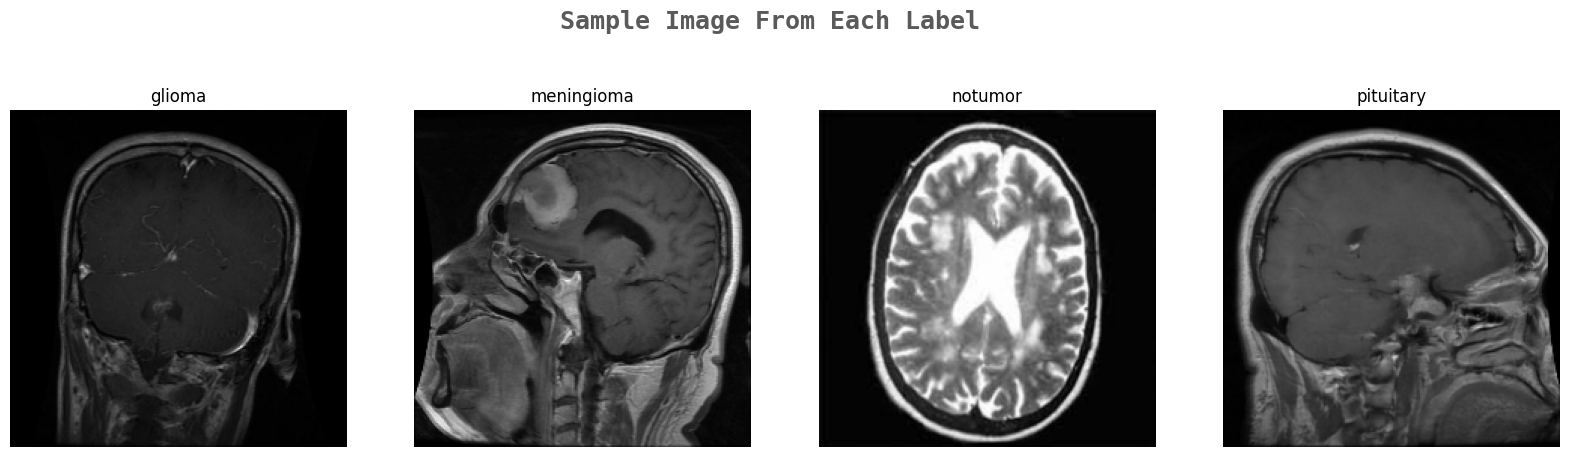

In [ ]:
# In ra một vài mẫu ảnh test:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_test[j]==i:
            ax[k].imshow(X_test[j])
            ax[k].set_title(y_test[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
# One-hot encoding cho y_test:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

print(f"Test set shape: {X_test.shape}")
print(f"Labels test shape: {y_test.shape}")

Test set shape: (91, 224, 224, 3)
Labels test shape: (91, 4)


In [ ]:
# Delete y_test_new:
del y_test_new
import gc
gc.collect()
print("Đã giải phóng bộ nhớ của biến y_test_new.")

Đã giải phóng bộ nhớ của biến y_test_new.


# 2. Thực nghiệm với VGG16:

## 2.1. Load và build mô hình VGG16:

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# Load mô hình vgg16:
vgg16 = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size,image_size,3)
)
vgg16.trainable = False

In [ ]:
# Thêm head theo kiến trúc SOTA:
model_vgg16 = vgg16.output
model_vgg16 = GlobalAveragePooling2D()(model_vgg16) # Lấy tb các kênh
model_vgg16 = Dense(512, activation="relu")(model_vgg16) # Hàm kích hoạt phi tuyến
model_vgg16 = Dropout(0.5)(model_vgg16) # Drop out giảm overfitting
model_vgg16 = Dense(256, activation="relu")(model_vgg16)
model_vgg16 = Dropout(0.3)(model_vgg16)
output = Dense(4, activation="softmax")(model_vgg16) # Softmax regression

model_vgg16 = Model(inputs=vgg16.input, outputs=output)

model_vgg16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,109,700 (57.64 MB)

 Trainable params: 395,012 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Biên dịch mô hình lần 1 để train head:
model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
tensorboard_vgg16 = TensorBoard(
    log_dir='log_vgg16',
)

checkpoint_vgg16 = ModelCheckpoint(
    "vgg16_best.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_vgg16 = ReduceLROnPlateau(
    monitor='val_loss', # Theo dõi val_loss để giảm learning rate
    factor=0.2, # Mức giảm lr
    patience=3, # Chờ cải thiện val_acc
    min_delta=1e-4, # Mức cải thiện thấp nhất chấp nhận
    min_lr=1e-7, # Giá trị lr thấp nhất đc giảm
    verbose=1
)

# Thêm early stopping:
early_stopping_vgg16 = EarlyStopping(
    monitor='val_loss', # Theo dõi val_loss để dừng
    patience=5, # Chờ val_loss tăng
    verbose=1
)


## 2.2. Finetune mô hình:

In [ ]:
# Huấn luyện head:
history_vgg16_head = model_vgg16.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=32,
                              epochs=20,
                              verbose=1,
                              callbacks=[tensorboard_vgg16, checkpoint_vgg16, reduce_lr_vgg16, early_stopping_vgg16])

Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6259 - loss: 1.5008
Epoch 1: val_loss improved from inf to 0.39240, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 87s 236ms/step - accuracy: 0.6262 - loss: 1.4987 - val_accuracy: 0.8637 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8196 - loss: 0.4956
Epoch 2: val_loss improved from 0.39240 to 0.35072, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 57s 187ms/step - accuracy: 0.8197 - loss: 0.4955 - val_accuracy: 0.8748 - val_loss: 0.3507 - learning_rate: 0.0010
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8540 - loss: 0.4045
Epoch 3: val_loss did not improve from 0.35072
302/302 ━━━━━━━━━━━━━━━━━━━━ 57s 190ms/step - accuracy: 0.8540 - loss: 0.4044 - val_accuracy: 0.8732 - val_loss: 0.3633 - learning_rate: 0.0010
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8694 - loss: 0.3445
Epoch 4: val_loss improved from 0.35072 to 0.24314, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.8694 - loss: 0.3444 - val_accuracy: 0.9080 - val_loss: 0.2431 - learning_rate: 0.0010
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8959 - loss: 0.2963
Epoch 5: val_loss improved from 0.24314 to 0.22092, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.8959 - loss: 0.2963 - val_accuracy: 0.9225 - val_loss: 0.2209 - learning_rate: 0.0010
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9026 - loss: 0.2618
Epoch 6: val_loss improved from 0.22092 to 0.21232, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 194ms/step - accuracy: 0.9026 - loss: 0.2618 - val_accuracy: 0.9271 - val_loss: 0.2123 - learning_rate: 0.0010
Epoch 7/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9141 - loss: 0.2318
Epoch 7: val_loss did not improve from 0.21232
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9141 - loss: 0.2318 - val_accuracy: 0.9237 - val_loss: 0.2184 - learning_rate: 0.0010
Epoch 8/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9189 - loss: 0.2226
Epoch 8: val_loss improved from 0.21232 to 0.21012, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - accuracy: 0.9189 - loss: 0.2226 - val_accuracy: 0.9229 - val_loss: 0.2101 - learning_rate: 0.0010
Epoch 9/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9165 - loss: 0.2354
Epoch 9: val_loss did not improve from 0.21012
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9165 - loss: 0.2354 - val_accuracy: 0.9287 - val_loss: 0.2104 - learning_rate: 0.0010
Epoch 10/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9261 - loss: 0.1985
Epoch 10: val_loss improved from 0.21012 to 0.17611, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - accuracy: 0.9261 - loss: 0.1985 - val_accuracy: 0.9354 - val_loss: 0.1761 - learning_rate: 0.0010
Epoch 11/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9269 - loss: 0.1946
Epoch 11: val_loss improved from 0.17611 to 0.17528, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - accuracy: 0.9269 - loss: 0.1946 - val_accuracy: 0.9366 - val_loss: 0.1753 - learning_rate: 0.0010
Epoch 12/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9313 - loss: 0.1825
Epoch 12: val_loss did not improve from 0.17528
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9313 - loss: 0.1824 - val_accuracy: 0.9387 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 13/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9380 - loss: 0.1721
Epoch 13: val_loss improved from 0.17528 to 0.15629, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 194ms/step - accuracy: 0.9380 - loss: 0.1721 - val_accuracy: 0.9532 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 14/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9376 - loss: 0.1711
Epoch 14: val_loss did not improve from 0.15629
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9376 - loss: 0.1711 - val_accuracy: 0.9329 - val_loss: 0.1731 - learning_rate: 0.0010
Epoch 15/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9470 - loss: 0.1465
Epoch 15: val_loss did not improve from 0.15629
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9470 - loss: 0.1465 - val_accuracy: 0.9366 - val_loss: 0.1995 - learning_rate: 0.0010
Epoch 16/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9435 - loss: 0.1547
Epoch 16: val_loss improved from 0.15629 to 0.15012, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - accuracy: 0.9435 - loss: 0.1548 - val_accuracy: 0.9581 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 17/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9467 - loss: 0.1421
Epoch 17: val_loss improved from 0.15012 to 0.14259, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - accuracy: 0.9467 - loss: 0.1421 - val_accuracy: 0.9540 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 18/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9557 - loss: 0.1218
Epoch 18: val_loss did not improve from 0.14259
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9557 - loss: 0.1219 - val_accuracy: 0.9544 - val_loss: 0.1498 - learning_rate: 0.0010
Epoch 19/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9371 - loss: 0.1594
Epoch 19: val_loss did not improve from 0.14259
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9371 - loss: 0.1594 - val_accuracy: 0.9461 - val_loss: 0.1561 - learning_rate: 0.0010
Epoch 20/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9478 - loss: 0.1455
Epoch 20: val_loss did not improve from 0.14259

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9478 - loss: 0.1455 

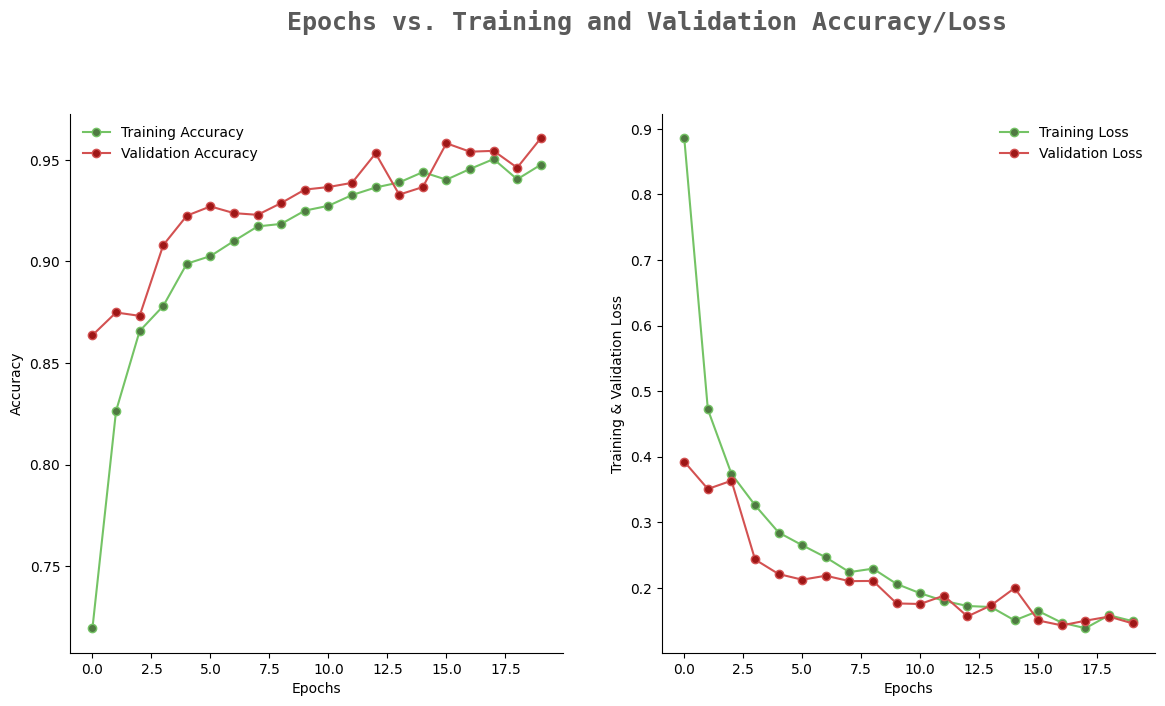

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_vgg16_head.history['accuracy']
train_loss = history_vgg16_head.history['loss']
val_acc = history_vgg16_head.history['val_accuracy']
val_loss = history_vgg16_head.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
# Mở block cuối để fine tune:
for layer in vgg16.layers:
    if "block5" in layer.name:
        layer.trainable = True

In [ ]:
# Compile lại với lr nhỏ hơn:
model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Huấn luyện mô hình với data augmentation:
history_vgg16 = model_vgg16.fit(X_train, y_train,
                              batch_size=32,
                              validation_data=(X_val, y_val),
                              epochs=30,
                              verbose=1,
                              callbacks=[tensorboard_vgg16, checkpoint_vgg16, reduce_lr_vgg16, early_stopping_vgg16])

Epoch 1/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9578 - loss: 0.1199
Epoch 1: val_loss improved from 0.14259 to 0.13616, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 85s 261ms/step - accuracy: 0.9578 - loss: 0.1199 - val_accuracy: 0.9623 - val_loss: 0.1362 - learning_rate: 1.0000e-05
Epoch 2/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9772 - loss: 0.0734
Epoch 2: val_loss improved from 0.13616 to 0.11282, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 214ms/step - accuracy: 0.9772 - loss: 0.0733 - val_accuracy: 0.9639 - val_loss: 0.1128 - learning_rate: 1.0000e-05
Epoch 3/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9827 - loss: 0.0516
Epoch 3: val_loss improved from 0.11282 to 0.09222, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 215ms/step - accuracy: 0.9827 - loss: 0.0516 - val_accuracy: 0.9776 - val_loss: 0.0922 - learning_rate: 1.0000e-05
Epoch 4/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9886 - loss: 0.0410
Epoch 4: val_loss improved from 0.09222 to 0.09006, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.9886 - loss: 0.0410 - val_accuracy: 0.9760 - val_loss: 0.0901 - learning_rate: 1.0000e-05
Epoch 5/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9873 - loss: 0.0394
Epoch 5: val_loss improved from 0.09006 to 0.08991, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.9873 - loss: 0.0394 - val_accuracy: 0.9785 - val_loss: 0.0899 - learning_rate: 1.0000e-05
Epoch 6/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9923 - loss: 0.0262
Epoch 6: val_loss improved from 0.08991 to 0.07478, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.9923 - loss: 0.0262 - val_accuracy: 0.9809 - val_loss: 0.0748 - learning_rate: 1.0000e-05
Epoch 7/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9924 - loss: 0.0267
Epoch 7: val_loss improved from 0.07478 to 0.06905, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.9924 - loss: 0.0267 - val_accuracy: 0.9818 - val_loss: 0.0690 - learning_rate: 1.0000e-05
Epoch 8/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9934 - loss: 0.0200
Epoch 8: val_loss improved from 0.06905 to 0.06711, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.9934 - loss: 0.0201 - val_accuracy: 0.9838 - val_loss: 0.0671 - learning_rate: 1.0000e-05
Epoch 9/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9929 - loss: 0.0221
Epoch 9: val_loss did not improve from 0.06711
302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 215ms/step - accuracy: 0.9929 - loss: 0.0221 - val_accuracy: 0.9801 - val_loss: 0.0769 - learning_rate: 1.0000e-05
Epoch 10/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9953 - loss: 0.0143
Epoch 10: val_loss did not improve from 0.06711
302/302 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - accuracy: 0.9953 - loss: 0.0143 - val_accuracy: 0.9644 - val_loss: 0.1154 - learning_rate: 1.0000e-05
Epoch 11/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9922 - loss: 0.0218
Epoch 11: val_loss did not improve from 0.06711

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
302/302 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - accuracy: 0.9922 - los

302/302 ━━━━━━━━━━━━━━━━━━━━ 67s 220ms/step - accuracy: 0.9962 - loss: 0.0132 - val_accuracy: 0.9872 - val_loss: 0.0500 - learning_rate: 2.0000e-06
Epoch 13/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9983 - loss: 0.0071
Epoch 13: val_loss improved from 0.04999 to 0.04873, saving model to vgg16_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 67s 220ms/step - accuracy: 0.9983 - loss: 0.0071 - val_accuracy: 0.9888 - val_loss: 0.0487 - learning_rate: 2.0000e-06
Epoch 14/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9974 - loss: 0.0059
Epoch 14: val_loss did not improve from 0.04873
302/302 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - accuracy: 0.9974 - loss: 0.0059 - val_accuracy: 0.9867 - val_loss: 0.0524 - learning_rate: 2.0000e-06
Epoch 15/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9980 - loss: 0.0068
Epoch 15: val_loss did not improve from 0.04873
302/302 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9872 - val_loss: 0.0543 - learning_rate: 2.0000e-06
Epoch 16/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9992 - loss: 0.0056
Epoch 16: val_loss did not improve from 0.04873

Epoch 16: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
302/302 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - accuracy: 0.9992 - lo

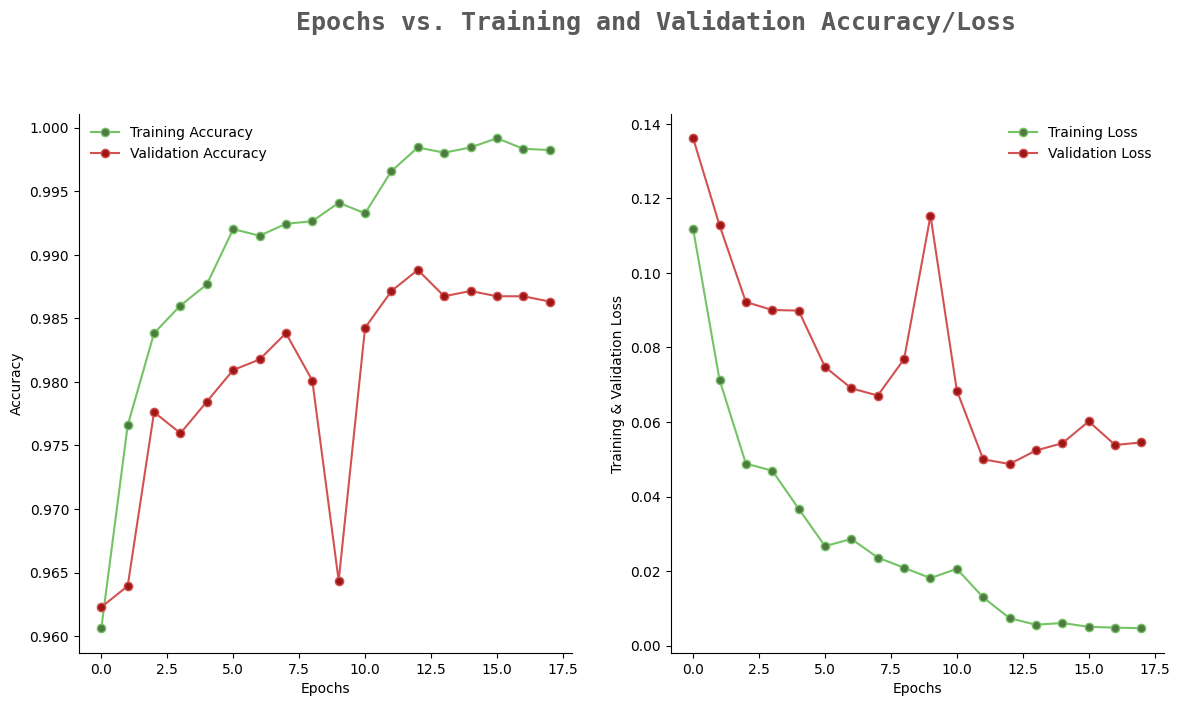

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(18)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_vgg16.history['accuracy']
train_loss = history_vgg16.history['loss']
val_acc = history_vgg16.history['val_accuracy']
val_loss = history_vgg16.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

## 2.3. Đánh giá mô hình trên tập test:

In [ ]:
import time
import numpy as np

# ĐO INFERENCE TIME:
start = time.time()
pred_vgg16 = model_vgg16.predict(X_test, verbose=0)
end = time.time()

# TÍNH THỜI GIAN:
total_time = end - start
avg_time_per_image = total_time / len(X_test)

# CHUYỂN ĐỔI OUTPUT:
pred_vgg16 = np.argmax(pred_vgg16, axis=1)
y_test_new = np.argmax(y_test, axis=1)

# IN KẾT QUẢ:
print(f"Total inference time: {total_time:.4f} seconds")
print(f"Average time per image: {avg_time_per_image*1000:.4f} ms/image")


Total inference time: 12.7864 seconds
Average time per image: 140.5102 ms/image


In [ ]:
print(classification_report(y_test_new,pred_vgg16))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        49
           1       0.92      0.92      0.92        13
           2       1.00      0.95      0.97        20
           3       0.90      1.00      0.95         9

    accuracy                           0.97        91
   macro avg       0.95      0.96      0.96        91
weighted avg       0.97      0.97      0.97        91



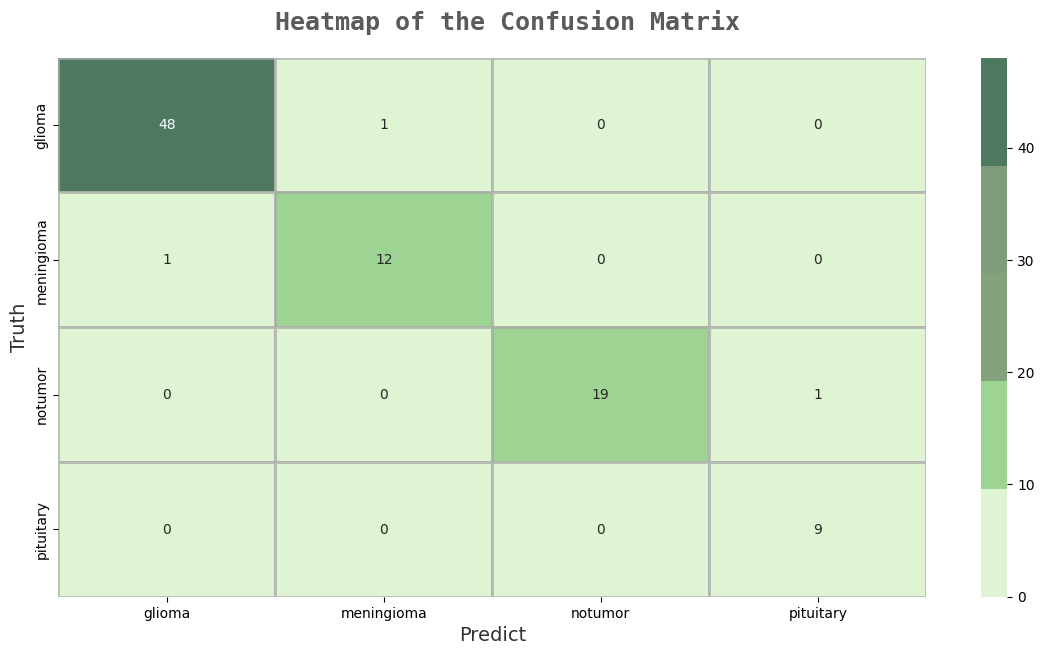

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred_vgg16),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
# Hiển thị trục truth và predict:
ax.set_xlabel('Predict',fontsize=14,color=colors_dark[1])
ax.set_ylabel('Truth',fontsize=14,color=colors_dark[1])
# Hiển thị tiêu đề:
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## 2.4. Tính toán chỉ số False Negative Rate của mô hình:

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_false_negative_rate(y_true_numerical, y_pred_numerical, all_labels_list):
    """
    Calculates the False Negative Rate for actual tumor images misclassified as 'no_tumor'.

    Args:
        y_true_numerical (np.ndarray): True labels (numerical).
        y_pred_numerical (np.ndarray): Predicted labels (numerical).
        all_labels_list (list): List of all possible string labels, where 'notumor' is identified.

    Returns:
        float: The False Negative Rate.
    """
    # Get the confusion matrix
    cm = confusion_matrix(y_true_numerical, y_pred_numerical)

    # Find the index of 'no_tumor'
    no_tumor_idx = all_labels_list.index('notumor')

    # Identify tumor classes (all except 'no_tumor')
    tumor_indices = [i for i, label in enumerate(all_labels_list) if label != 'notumor']

    # Sum of actual tumor images
    total_actual_tumor = 0
    for idx in tumor_indices:
        total_actual_tumor += cm[idx, :].sum()

    # Number of actual tumor images incorrectly predicted as 'no_tumor' (False Negatives in this context)
    # These are cases where true label is a tumor, but predicted label is 'no_tumor'
    misclassified_as_no_tumor = 0
    for idx in tumor_indices:
        misclassified_as_no_tumor += cm[idx, no_tumor_idx]

    if total_actual_tumor == 0:
        return 0.0 # Avoid division by zero if there are no actual tumor cases

    false_negative_rate = misclassified_as_no_tumor / total_actual_tumor

    print(f"Total actual tumor images: {total_actual_tumor}")
    print(f"Number of actual tumor images misclassified as 'no_tumor': {misclassified_as_no_tumor}")
    print(f"False Negative Rate (actual tumor predicted as no_tumor): {false_negative_rate:.4f}")

    return false_negative_rate


In [ ]:
# Apply the function to the original model's results
print("False Negative Rate for the VGG16 model:")
vgg16_fnr = calculate_false_negative_rate(y_test_new, pred_vgg16, labels)

False Negative Rate for the VGG16 model:
Total actual tumor images: 71
Number of actual tumor images misclassified as 'no_tumor': 0
False Negative Rate (actual tumor predicted as no_tumor): 0.0000


- Như vậy mô hình VGG16 đạt được ***acc = 0.97, time inference = 140.5102 ms/image và FNR = 0.0000*** trên tập dữ liệu test.

In [ ]:
# Lưu mô hình về drive:
model_vgg16.save("/content/drive/MyDrive/Image_Processing_Application/Đồ Án/vgg16_model.keras")

- Tiếp theo, thực nghiệm trên mô hình MobileNetV2:

# 3. Thực nghiệm với MobileNetV2:

## 3.1. Load và build mô hình MobileNetV2:

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 model
mobilenetv2 = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

# Freeze the base layers of MobileNetV2
mobilenetv2.trainable = False

# Add custom classification head
model_mobilenetv2 = mobilenetv2.output
model_mobilenetv2 = GlobalAveragePooling2D()(model_mobilenetv2)
model_mobilenetv2 = Dense(512, activation='relu')(model_mobilenetv2)
model_mobilenetv2 = Dropout(0.5)(model_mobilenetv2)
model_mobilenetv2 = Dense(256, activation='relu')(model_mobilenetv2)
model_mobilenetv2 = Dropout(0.3)(model_mobilenetv2)
output = Dense(4, activation='softmax')(model_mobilenetv2)

# Create the new model
model_mobilenetv2 = Model(inputs=mobilenetv2.input, outputs=output)

# Print model summary
model_mobilenetv2.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,046,212 (11.62 MB)

 Trainable params: 788,228 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 3.2. Finetune mô hình:

In [ ]:
# Biên dịch mô hình lần 1 để train head:
model_mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
tensorboard_mobilenetv2 = TensorBoard(
    log_dir='log_mobilenetv2',
)

checkpoint_mobilenetv2 = ModelCheckpoint(
    "mobilenetv2_best.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_mobilenetv2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_delta=1e-4,
    min_lr=1e-7,
    verbose=1
)

early_stopping_mobilenetv2 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

print("Callbacks for MobileNetV2 defined successfully.")

Callbacks for MobileNetV2 defined successfully.


In [ ]:
# Huấn luyện head:
history_mobilenetv2_head = model_mobilenetv2.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=32,
                              epochs=20,
                              verbose=1,
                              callbacks=[tensorboard_mobilenetv2, checkpoint_mobilenetv2, reduce_lr_mobilenetv2, early_stopping_mobilenetv2])

Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5869 - loss: 1.0208
Epoch 1: val_loss improved from inf to 0.54742, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.5871 - loss: 1.0202 - val_accuracy: 0.7862 - val_loss: 0.5474 - learning_rate: 0.0010
Epoch 2/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7337 - loss: 0.6565
Epoch 2: val_loss improved from 0.54742 to 0.48438, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7338 - loss: 0.6563 - val_accuracy: 0.8168 - val_loss: 0.4844 - learning_rate: 0.0010
Epoch 3/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7743 - loss: 0.5617
Epoch 3: val_loss improved from 0.48438 to 0.45071, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7743 - loss: 0.5617 - val_accuracy: 0.8201 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 4/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7929 - loss: 0.5208
Epoch 4: val_loss improved from 0.45071 to 0.42614, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7930 - loss: 0.5208 - val_accuracy: 0.8305 - val_loss: 0.4261 - learning_rate: 0.0010
Epoch 5/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8050 - loss: 0.5028
Epoch 5: val_loss improved from 0.42614 to 0.40503, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.8051 - loss: 0.5027 - val_accuracy: 0.8479 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 6/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8237 - loss: 0.4582
Epoch 6: val_loss improved from 0.40503 to 0.38294, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8237 - loss: 0.4581 - val_accuracy: 0.8624 - val_loss: 0.3829 - learning_rate: 0.0010
Epoch 7/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8307 - loss: 0.4449
Epoch 7: val_loss improved from 0.38294 to 0.35556, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8307 - loss: 0.4449 - val_accuracy: 0.8686 - val_loss: 0.3556 - learning_rate: 0.0010
Epoch 8/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8247 - loss: 0.4359
Epoch 8: val_loss improved from 0.35556 to 0.34950, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8248 - loss: 0.4359 - val_accuracy: 0.8678 - val_loss: 0.3495 - learning_rate: 0.0010
Epoch 9/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8472 - loss: 0.3924
Epoch 9: val_loss improved from 0.34950 to 0.34645, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8472 - loss: 0.3925 - val_accuracy: 0.8719 - val_loss: 0.3465 - learning_rate: 0.0010
Epoch 10/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8516 - loss: 0.3761
Epoch 10: val_loss did not improve from 0.34645
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8515 - loss: 0.3762 - val_accuracy: 0.8682 - val_loss: 0.3654 - learning_rate: 0.0010
Epoch 11/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8574 - loss: 0.3611
Epoch 11: val_loss improved from 0.34645 to 0.33846, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8574 - loss: 0.3612 - val_accuracy: 0.8703 - val_loss: 0.3385 - learning_rate: 0.0010
Epoch 12/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8518 - loss: 0.3639
Epoch 12: val_loss improved from 0.33846 to 0.33536, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8518 - loss: 0.3639 - val_accuracy: 0.8740 - val_loss: 0.3354 - learning_rate: 0.0010
Epoch 13/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8665 - loss: 0.3522
Epoch 13: val_loss improved from 0.33536 to 0.32995, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8664 - loss: 0.3522 - val_accuracy: 0.8695 - val_loss: 0.3300 - learning_rate: 0.0010
Epoch 14/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8601 - loss: 0.3536
Epoch 14: val_loss did not improve from 0.32995
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8601 - loss: 0.3536 - val_accuracy: 0.8744 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 15/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8698 - loss: 0.3308
Epoch 15: val_loss improved from 0.32995 to 0.32008, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8698 - loss: 0.3308 - val_accuracy: 0.8732 - val_loss: 0.3201 - learning_rate: 0.0010
Epoch 16/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8694 - loss: 0.3257
Epoch 16: val_loss did not improve from 0.32008
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8694 - loss: 0.3257 - val_accuracy: 0.8724 - val_loss: 0.3238 - learning_rate: 0.0010
Epoch 17/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8801 - loss: 0.3125
Epoch 17: val_loss improved from 0.32008 to 0.31041, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8801 - loss: 0.3125 - val_accuracy: 0.8736 - val_loss: 0.3104 - learning_rate: 0.0010
Epoch 18/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8800 - loss: 0.2943
Epoch 18: val_loss improved from 0.31041 to 0.30784, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8800 - loss: 0.2944 - val_accuracy: 0.8877 - val_loss: 0.3078 - learning_rate: 0.0010
Epoch 19/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8771 - loss: 0.2978
Epoch 19: val_loss improved from 0.30784 to 0.30111, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8771 - loss: 0.2978 - val_accuracy: 0.8852 - val_loss: 0.3011 - learning_rate: 0.0010
Epoch 20/20
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8774 - loss: 0.3106
Epoch 20: val_loss improved from 0.30111 to 0.29773, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8774 - loss: 0.3105 - val_accuracy: 0.8856 - val_loss: 0.2977 - learning_rate: 0.0010


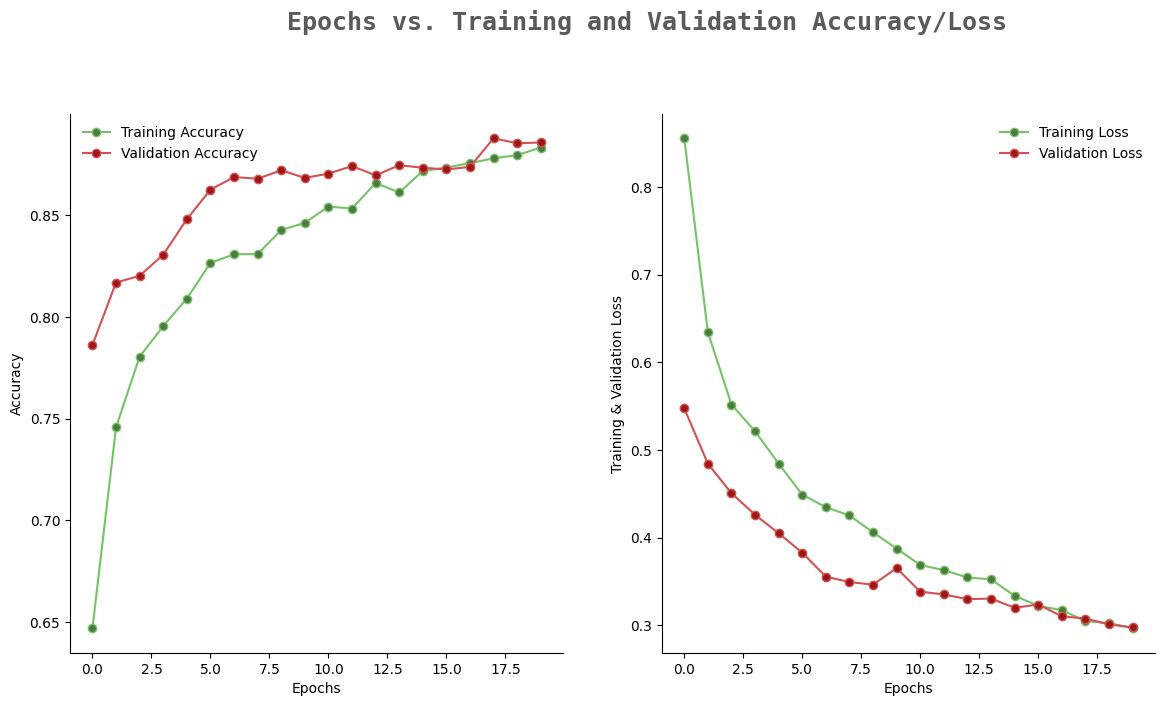

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_mobilenetv2_head.history['accuracy']
train_loss = history_mobilenetv2_head.history['loss']
val_acc = history_mobilenetv2_head.history['val_accuracy']
val_loss = history_mobilenetv2_head.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
# Mở thêm block cuối base để train sâu:
for layer in mobilenetv2.layers:
    layer.trainable = False
    if "block_16" in layer.name or "Conv_1" in layer.name:
        layer.trainable = True

In [ ]:
# Biên dịch mô hình lần 2 để train sâu hơn:
model_mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Fine-tune lại mô hình:
history_mobilenetv2_2 = model_mobilenetv2.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=32,
                              epochs=30,
                              verbose=1,
                              callbacks=[tensorboard_mobilenetv2, checkpoint_mobilenetv2, reduce_lr_mobilenetv2, early_stopping_mobilenetv2])

Epoch 1/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6931 - loss: 1.2554
Epoch 1: val_loss did not improve from 0.29773
302/302 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.6933 - loss: 1.2537 - val_accuracy: 0.7439 - val_loss: 0.9633 - learning_rate: 1.0000e-04
Epoch 2/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8475 - loss: 0.3977
Epoch 2: val_loss did not improve from 0.29773
302/302 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8476 - loss: 0.3976 - val_accuracy: 0.6846 - val_loss: 1.3488 - learning_rate: 1.0000e-04
Epoch 3/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8836 - loss: 0.2986
Epoch 3: val_loss did not improve from 0.29773
302/302 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8836 - loss: 0.2985 - val_accuracy: 0.7936 - val_loss: 0.7564 - learning_rate: 1.0000e-04
Epoch 4/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9059 - loss: 0.2349
Epoch 4: val_loss did not improve from 0.29773
302/302 ━━━━━━━━━━━━━━━

302/302 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9428 - loss: 0.1577 - val_accuracy: 0.9150 - val_loss: 0.2688 - learning_rate: 1.0000e-04
Epoch 8/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9510 - loss: 0.1342
Epoch 8: val_loss did not improve from 0.26884
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9509 - loss: 0.1343 - val_accuracy: 0.8135 - val_loss: 1.2032 - learning_rate: 1.0000e-04
Epoch 9/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9523 - loss: 0.1230
Epoch 9: val_loss did not improve from 0.26884
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9523 - loss: 0.1230 - val_accuracy: 0.8968 - val_loss: 0.4319 - learning_rate: 1.0000e-04
Epoch 10/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9582 - loss: 0.1148
Epoch 10: val_loss improved from 0.26884 to 0.25233, saving model to mobilenetv2_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9581 - loss: 0.1148 - val_accuracy: 0.9266 - val_loss: 0.2523 - learning_rate: 1.0000e-04
Epoch 11/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9625 - loss: 0.1045
Epoch 11: val_loss did not improve from 0.25233
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9625 - loss: 0.1045 - val_accuracy: 0.9109 - val_loss: 0.3151 - learning_rate: 1.0000e-04
Epoch 12/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9707 - loss: 0.0834
Epoch 12: val_loss did not improve from 0.25233
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9707 - loss: 0.0835 - val_accuracy: 0.9163 - val_loss: 0.3543 - learning_rate: 1.0000e-04
Epoch 13/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9722 - loss: 0.0810
Epoch 13: val_loss did not improve from 0.25233

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9722 - loss: 0.

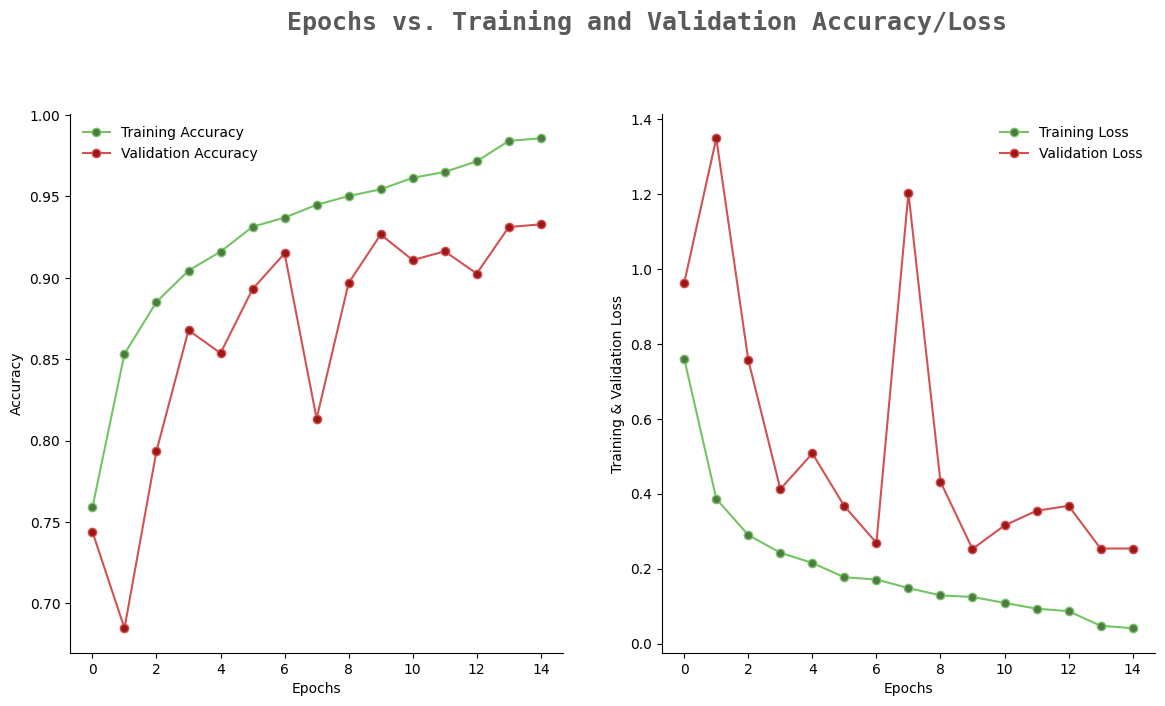

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_mobilenetv2_2.history['accuracy']
train_loss = history_mobilenetv2_2.history['loss']
val_acc = history_mobilenetv2_2.history['val_accuracy']
val_loss = history_mobilenetv2_2.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

## 3.3. Đánh giá mô hình trên tập test:

In [ ]:
import time
import numpy as np

# ĐO INFERENCE TIME:
start = time.time()
pred_mobilenetv2 = model_mobilenetv2.predict(X_test, verbose=0)
end = time.time()

# TÍNH THỜI GIAN:
total_time = end - start
avg_time_per_image = total_time / len(X_test)

# CHUYỂN ĐỔI OUTPUT:
pred_mobilenetv2 = np.argmax(pred_mobilenetv2, axis=1)
y_test_new = np.argmax(y_test, axis=1)

# IN KẾT QUẢ:
print(f"Total inference time: {total_time:.4f} seconds")
print(f"Average time per image: {avg_time_per_image*1000:.4f} ms/image")


Total inference time: 8.2819 seconds
Average time per image: 91.0094 ms/image


In [ ]:
print(classification_report(y_test_new,pred_mobilenetv2))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        49
           1       0.71      0.92      0.80        13
           2       1.00      0.70      0.82        20
           3       0.89      0.89      0.89         9

    accuracy                           0.90        91
   macro avg       0.88      0.87      0.87        91
weighted avg       0.92      0.90      0.90        91



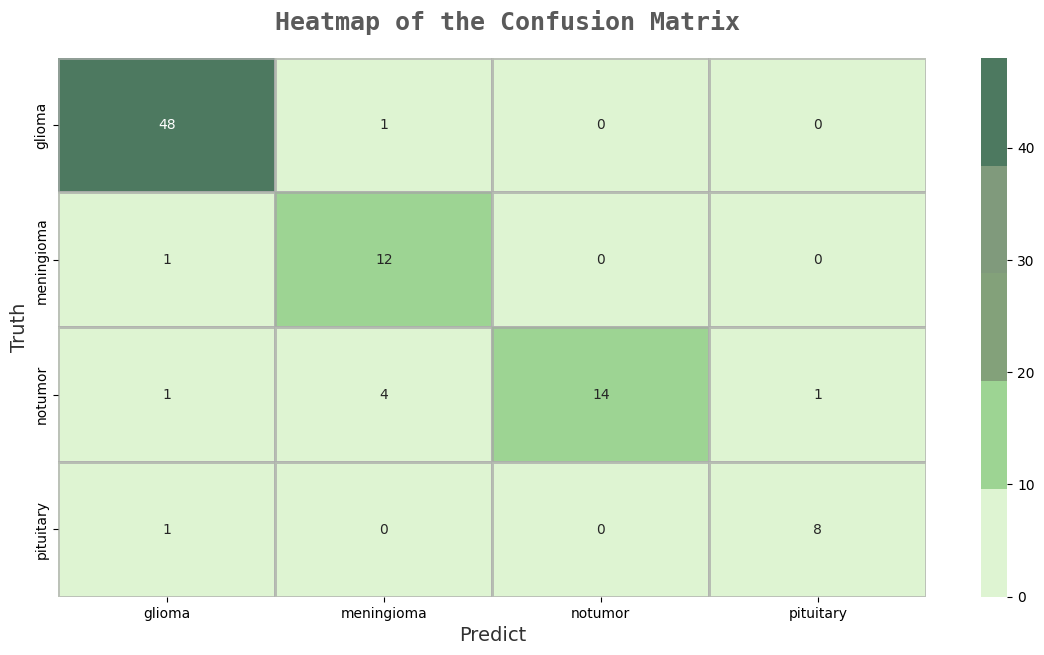

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred_mobilenetv2),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
# Hiển thị trục truth và predict:
ax.set_xlabel('Predict',fontsize=14,color=colors_dark[1])
ax.set_ylabel('Truth',fontsize=14,color=colors_dark[1])
# Hiển thị tiêu đề:
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## 3.4. Đánh giá chỉ số FNR của mô hình:

In [ ]:
# Apply the function to the original model's results
print("False Negative Rate for the MobileNetV2 model:")
mobilenetv2_fnr = calculate_false_negative_rate(y_test_new, pred_mobilenetv2, labels)

False Negative Rate for the MobileNetV2 model:
Total actual tumor images: 71
Number of actual tumor images misclassified as 'no_tumor': 0
False Negative Rate (actual tumor predicted as no_tumor): 0.0000


- Như vậy, mô hình MobileNetV2 đạt được ***acc = 0.90, time inference = 91.0094 ms/image và FNR = 0.0000*** trên tập test.

In [ ]:
# Lưu mô hình về drive:
model_mobilenetv2.save("/content/drive/MyDrive/Image_Processing_Application/Đồ Án/mobilenetv2_model.keras")

# 4. Thực nghiệm với ResNet50:

## 4.1. Load và buil mô hình ResNet50:

In [ ]:
# Load mô hình ResNet50:
from tensorflow.keras.applications import ResNet50

base = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
base.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Thêm head theo kiến trúc SOTA:

# Add custom classification head
resnet50 = base.output
resnet50 = GlobalAveragePooling2D()(resnet50)
resnet50 = Dense(512, activation='relu')(resnet50)
resnet50 = Dropout(0.5)(resnet50)
resnet50 = Dense(256, activation='relu')(resnet50)
resnet50 = Dropout(0.3)(resnet50)
output = Dense(4, activation='softmax')(resnet50)

# Create the new model
resnet50 = Model(inputs=base.input, outputs=output)

# Print model summary
resnet50.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,769,156 (94.49 MB)

 Trainable params: 1,181,444 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 4.2. Fine-tune model:

In [ ]:
# Biên dịch mô hình lần 1 để train head:
resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
tensorboard_resnet50 = TensorBoard(
    log_dir='log_resnet50',
)

checkpoint_resnet50 = ModelCheckpoint(
    "resnet50_best.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_resnet50 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_delta=1e-4,
    min_lr=1e-7,
    verbose=1
)

early_stopping_resnet50 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

print("Callbacks for ResNet50 defined successfully.")

Callbacks for ResNet50 defined successfully.


In [ ]:
# Fine-tune head:
history_resnet50_head = resnet50.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=32,
                              epochs=20,
                              verbose=1,
                              callbacks=[tensorboard_resnet50, checkpoint_resnet50, reduce_lr_resnet50, early_stopping_resnet50])

Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6726 - loss: 0.8744
Epoch 1: val_loss improved from inf to 0.35302, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 171ms/step - accuracy: 0.6728 - loss: 0.8737 - val_accuracy: 0.8802 - val_loss: 0.3530 - learning_rate: 0.0010
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8266 - loss: 0.4464
Epoch 2: val_loss improved from 0.35302 to 0.28369, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 56s 109ms/step - accuracy: 0.8267 - loss: 0.4463 - val_accuracy: 0.8877 - val_loss: 0.2837 - learning_rate: 0.0010
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8608 - loss: 0.3654
Epoch 3: val_loss improved from 0.28369 to 0.23426, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.8608 - loss: 0.3654 - val_accuracy: 0.9121 - val_loss: 0.2343 - learning_rate: 0.0010
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8681 - loss: 0.3456
Epoch 4: val_loss improved from 0.23426 to 0.23160, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.8681 - loss: 0.3456 - val_accuracy: 0.9163 - val_loss: 0.2316 - learning_rate: 0.0010
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8930 - loss: 0.2913
Epoch 5: val_loss improved from 0.23160 to 0.23139, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.8929 - loss: 0.2913 - val_accuracy: 0.9039 - val_loss: 0.2314 - learning_rate: 0.0010
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8872 - loss: 0.2988
Epoch 6: val_loss improved from 0.23139 to 0.18928, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.8872 - loss: 0.2988 - val_accuracy: 0.9217 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 7/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9073 - loss: 0.2532
Epoch 7: val_loss did not improve from 0.18928
302/302 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - accuracy: 0.9073 - loss: 0.2532 - val_accuracy: 0.9254 - val_loss: 0.1902 - learning_rate: 0.0010
Epoch 8/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9201 - loss: 0.2228
Epoch 8: val_loss improved from 0.18928 to 0.16733, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.9200 - loss: 0.2228 - val_accuracy: 0.9345 - val_loss: 0.1673 - learning_rate: 0.0010
Epoch 9/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9216 - loss: 0.2097
Epoch 9: val_loss did not improve from 0.16733
302/302 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.9215 - loss: 0.2098 - val_accuracy: 0.9370 - val_loss: 0.1685 - learning_rate: 0.0010
Epoch 10/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9180 - loss: 0.2226
Epoch 10: val_loss did not improve from 0.16733
302/302 ━━━━━━━━━━━━━━━━━━━━ 45s 118ms/step - accuracy: 0.9180 - loss: 0.2226 - val_accuracy: 0.9378 - val_loss: 0.1691 - learning_rate: 0.0010
Epoch 11/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9306 - loss: 0.1838
Epoch 11: val_loss improved from 0.16733 to 0.15168, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.9306 - loss: 0.1839 - val_accuracy: 0.9490 - val_loss: 0.1517 - learning_rate: 0.0010
Epoch 12/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9279 - loss: 0.1887
Epoch 12: val_loss did not improve from 0.15168
302/302 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.9279 - loss: 0.1887 - val_accuracy: 0.9366 - val_loss: 0.1596 - learning_rate: 0.0010
Epoch 13/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9296 - loss: 0.1866
Epoch 13: val_loss improved from 0.15168 to 0.14679, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.9296 - loss: 0.1866 - val_accuracy: 0.9432 - val_loss: 0.1468 - learning_rate: 0.0010
Epoch 14/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9376 - loss: 0.1712
Epoch 14: val_loss did not improve from 0.14679
302/302 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - accuracy: 0.9376 - loss: 0.1712 - val_accuracy: 0.9436 - val_loss: 0.1470 - learning_rate: 0.0010
Epoch 15/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9365 - loss: 0.1743
Epoch 15: val_loss improved from 0.14679 to 0.13554, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9365 - loss: 0.1743 - val_accuracy: 0.9519 - val_loss: 0.1355 - learning_rate: 0.0010
Epoch 16/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9353 - loss: 0.1710
Epoch 16: val_loss did not improve from 0.13554
302/302 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.9353 - loss: 0.1710 - val_accuracy: 0.9561 - val_loss: 0.1377 - learning_rate: 0.0010
Epoch 17/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9344 - loss: 0.1698
Epoch 17: val_loss improved from 0.13554 to 0.12804, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.9344 - loss: 0.1698 - val_accuracy: 0.9548 - val_loss: 0.1280 - learning_rate: 0.0010
Epoch 18/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9417 - loss: 0.1583
Epoch 18: val_loss improved from 0.12804 to 0.12631, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.9417 - loss: 0.1583 - val_accuracy: 0.9528 - val_loss: 0.1263 - learning_rate: 0.0010
Epoch 19/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9454 - loss: 0.1400
Epoch 19: val_loss did not improve from 0.12631
302/302 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.9453 - loss: 0.1401 - val_accuracy: 0.9519 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 20/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9380 - loss: 0.1597
Epoch 20: val_loss did not improve from 0.12631
302/302 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.9380 - loss: 0.1597 - val_accuracy: 0.9540 - val_loss: 0.1315 - learning_rate: 0.0010


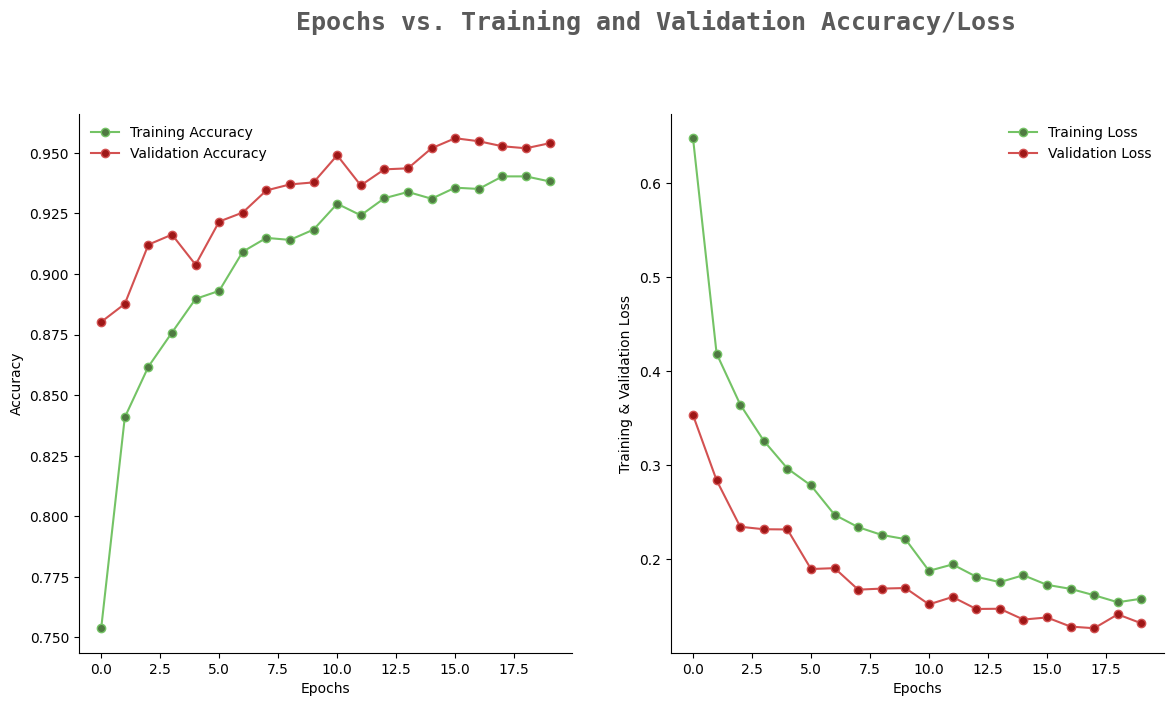

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_resnet50_head.history['accuracy']
train_loss = history_resnet50_head.history['loss']
val_acc = history_resnet50_head.history['val_accuracy']
val_loss = history_resnet50_head.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
# Mở thêm block cuối để finetune sâu:
for layer in base.layers:
    if "conv5" in layer.name or "conv4" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# Biên dịch mô hình lần 2 để train sâu:
resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Fine-tune đợt 2:
history_resnet50_2 = resnet50.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=32,
                              epochs=15,
                              verbose=1,
                              callbacks=[tensorboard_resnet50, checkpoint_resnet50, reduce_lr_resnet50, early_stopping_resnet50])

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8642 - loss: 0.4865
Epoch 1: val_loss did not improve from 0.12631
302/302 ━━━━━━━━━━━━━━━━━━━━ 119s 268ms/step - accuracy: 0.8644 - loss: 0.4859 - val_accuracy: 0.9573 - val_loss: 0.1663 - learning_rate: 1.0000e-04
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9673 - loss: 0.1093
Epoch 2: val_loss improved from 0.12631 to 0.06405, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 215ms/step - accuracy: 0.9673 - loss: 0.1092 - val_accuracy: 0.9801 - val_loss: 0.0641 - learning_rate: 1.0000e-04
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9806 - loss: 0.0629
Epoch 3: val_loss did not improve from 0.06405
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9806 - loss: 0.0629 - val_accuracy: 0.9818 - val_loss: 0.0679 - learning_rate: 1.0000e-04
Epoch 4/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9885 - loss: 0.0382
Epoch 4: val_loss improved from 0.06405 to 0.04245, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 60s 199ms/step - accuracy: 0.9885 - loss: 0.0382 - val_accuracy: 0.9888 - val_loss: 0.0425 - learning_rate: 1.0000e-04
Epoch 5/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9946 - loss: 0.0207
Epoch 5: val_loss did not improve from 0.04245
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.9946 - loss: 0.0207 - val_accuracy: 0.9809 - val_loss: 0.0815 - learning_rate: 1.0000e-04
Epoch 6/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9914 - loss: 0.0359
Epoch 6: val_loss did not improve from 0.04245
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.9914 - loss: 0.0360 - val_accuracy: 0.8777 - val_loss: 0.4700 - learning_rate: 1.0000e-04
Epoch 7/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9821 - loss: 0.0577
Epoch 7: val_loss did not improve from 0.04245

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.9821 - loss: 0.

302/302 ━━━━━━━━━━━━━━━━━━━━ 59s 196ms/step - accuracy: 0.9979 - loss: 0.0163 - val_accuracy: 0.9909 - val_loss: 0.0336 - learning_rate: 2.0000e-05
Epoch 9/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9977 - loss: 0.0072
Epoch 9: val_loss improved from 0.03362 to 0.03305, saving model to resnet50_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 208ms/step - accuracy: 0.9977 - loss: 0.0072 - val_accuracy: 0.9930 - val_loss: 0.0330 - learning_rate: 2.0000e-05
Epoch 10/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9994 - loss: 0.0028
Epoch 10: val_loss did not improve from 0.03305
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 191ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9917 - val_loss: 0.0351 - learning_rate: 2.0000e-05
Epoch 11/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9994 - loss: 0.0021
Epoch 11: val_loss did not improve from 0.03305
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9913 - val_loss: 0.0361 - learning_rate: 2.0000e-05
Epoch 12/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9998 - loss: 9.7888e-04
Epoch 12: val_loss did not improve from 0.03305

Epoch 12: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
302/302 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.9998 

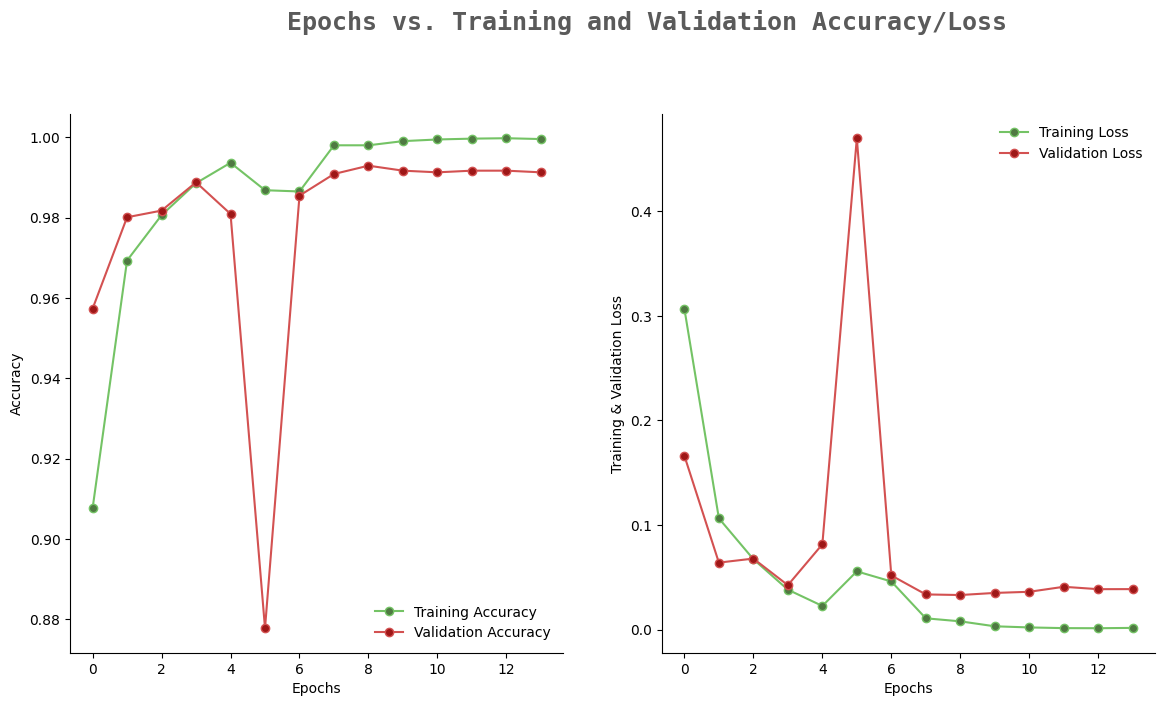

In [ ]:
# In ra quá trình huấn luyện:
filterwarnings('ignore')

epochs = [i for i in range(14)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history_resnet50_2.history['accuracy']
train_loss = history_resnet50_2.history['loss']
val_acc = history_resnet50_2.history['val_accuracy']
val_loss = history_resnet50_2.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

## 4.3. Đánh giá mô hình trên tập test:

In [ ]:
import time
import numpy as np

# ĐO INFERENCE TIME:
start = time.time()
pred_resnet50 = resnet50.predict(X_test, verbose=0)
end = time.time()

# TÍNH THỜI GIAN:
total_time = end - start
avg_time_per_image = total_time / len(X_test)

# CHUYỂN ĐỔI OUTPUT:
pred_resnet50 = np.argmax(pred_resnet50, axis=1)
y_test_new = np.argmax(y_test, axis=1)

# IN KẾT QUẢ:
print(f"Total inference time: {total_time:.4f} seconds")
print(f"Average time per image: {avg_time_per_image*1000:.4f} ms/image")


Total inference time: 10.5994 seconds
Average time per image: 116.4769 ms/image


In [ ]:
print(classification_report(y_test_new,pred_resnet50))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        49
           1       0.87      1.00      0.93        13
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00         9

    accuracy                           0.98        91
   macro avg       0.97      0.98      0.97        91
weighted avg       0.98      0.98      0.98        91



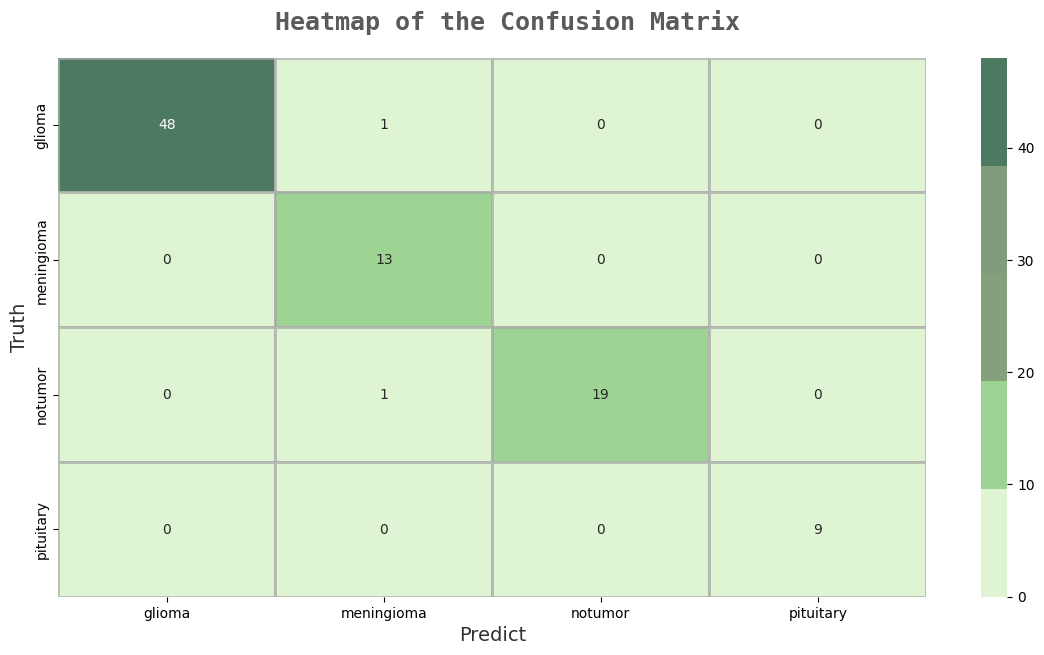

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred_resnet50),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
# Hiển thị trục truth và predict:
ax.set_xlabel('Predict',fontsize=14,color=colors_dark[1])
ax.set_ylabel('Truth',fontsize=14,color=colors_dark[1])
# Hiển thị tiêu đề:
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## 4.4. Đánh giá chỉ số FNR của model:

In [ ]:
# Apply the function to the original model's results
print("False Negative Rate for the ResNet50 model:")
mobilenetv2_fnr = calculate_false_negative_rate(y_test_new, pred_resnet50, labels)

False Negative Rate for the ResNet50 model:
Total actual tumor images: 71
Number of actual tumor images misclassified as 'no_tumor': 0
False Negative Rate (actual tumor predicted as no_tumor): 0.0000


In [ ]:
# Lưu mô hình về drive:
model_mobilenetv2.save("/content/drive/MyDrive/Image_Processing_Application/Đồ Án/resnet50_model.keras")

- Như vậy mô hình ResNet50 đạt được ***acc = 0.98, time inference = 116.4769 ms/image và FNR = 0.0000*** trên tập test!